In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_Domain_Adversarial_AE_OHE"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 32
shuffle = True
seed = None
latent_dim_size = 100

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

In [3]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

import math

In [4]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utility Functions

In [5]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [6]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
        
    return kfoldList

In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

# Model

In [8]:
def get_model():
    
    model = RandomForestClassifier(n_estimators=100, 
                                   max_depth = 5,
                                   criterion='gini', 
                                   bootstrap=True,
                                   oob_score=True)

#     model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False,
#                               learn_rate=0.001, eta=0.1, eval_metric='auc'
#                              )

#     model = xgb.XGBClassifier(objective="binary:logistic", 
#                               eval_metric='logloss',
#                               use_label_encoder=False, 
#                               max_depth=5)
    
#     model = SVC(kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False,
#                 tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=100, decision_function_shape='ovr', 
#                 break_ties=False, random_state=None)

#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Input(shape=(latent_dim_size,)))
#     model.add(tf.keras.layers.Dense(32,
#                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#     model.add(tf.keras.layers.Activation('relu'))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), 
#                   loss='binary_crossentropy', 
#                   metrics=None)
    
    return model

In [9]:
class GradientReversal(tf.keras.layers.Layer):
    """Flip the sign of gradient during training.
    based on https://github.com/michetonu/gradient_reversal_keras_tf
    ported to tf 2.x
    """

    def __init__(self, λ=1, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.λ = λ

    @staticmethod
    @tf.custom_gradient
    def reverse_gradient(x, λ):
        # @tf.custom_gradient suggested by Hoa's comment at
        # https://stackoverflow.com/questions/60234725/how-to-use-gradient-override-map-with-tf-gradienttape-in-tf2-0
        return tf.identity(x), lambda dy: (-dy, None)

    def call(self, x):
        return self.reverse_gradient(x, self.λ)

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        return super(GradientReversal, self).get_config() | {'λ': self.λ}

In [88]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DANN(input_seq_shape=(41,21)):
    
    hp_beta = 0.01
    
    hp_conv_activation = 'relu'
    hp_conv_filters_1 = 50
    hp_conv_kernel_length_1 = 10
    hp_conv_filters_2 = 50
    hp_conv_kernel_length_2 = 5
    hp_conv_stride = 1

    hp_latent_dim = latent_dim_size
    
    hp_dense_units = 32
    hp_dropout_prob = 0.5
    hp_dense_activation = 'relu'
    
    hp_learning_rate = 0.1
    hp_opt_func = 'adam'
    
    metric = None

    ###########################################################################
    ##### Encoder
    ###########################################################################
    
    ae_input = tf.keras.layers.Input(shape=input_seq_shape)

    xe = tf.keras.layers.Conv1D(hp_conv_filters_1, hp_conv_kernel_length_1,
                                strides = hp_conv_stride,
                                kernel_regularizer=tf.keras.regularizers.l2(hp_beta),
                                activation=hp_conv_activation
                               )(ae_input)

    xe = tf.keras.layers.Conv1D(hp_conv_filters_2, hp_conv_kernel_length_2,
                                strides = hp_conv_stride,
                                kernel_regularizer=tf.keras.regularizers.l2(hp_beta),
                                activation=hp_conv_activation
                               )(xe)
    
    xe = tf.keras.layers.Flatten()(xe)
    xe = tf.keras.layers.Dense(hp_latent_dim)(xe)

    encoder = tf.keras.models.Model(inputs=ae_input, outputs=xe)
    
    ###########################################################################
    ##### Decoder
    ###########################################################################
    
    dec_input = tf.keras.layers.Input(shape=(hp_latent_dim,))
    
    # xd = tf.keras.layers.RepeatVector(input_seq_shape[0]-hp_conv_kernel_length_1-hp_conv_kernel_length_2+2)(dec_input)

    xd = tf.keras.layers.Dense(hp_conv_filters_2 * (input_seq_shape[0]-hp_conv_kernel_length_1-hp_conv_kernel_length_2+2)
                              )(dec_input)
    
    xd = tf.keras.layers.Reshape((input_seq_shape[0]-hp_conv_kernel_length_1-hp_conv_kernel_length_2+2, hp_conv_filters_2)
                                )(xd)

    xd = tf.keras.layers.Conv1DTranspose(hp_conv_filters_2, hp_conv_kernel_length_2,
                                         strides = hp_conv_stride,
                                         kernel_regularizer=tf.keras.regularizers.l2(hp_beta),
                                         activation=hp_conv_activation
                                        )(xd)

    xd = tf.keras.layers.Conv1DTranspose(21, hp_conv_kernel_length_1,
                                         strides = hp_conv_stride,
                                         kernel_regularizer=tf.keras.regularizers.l2(hp_beta),
                                         activation='softmax'
                                        )(xd)

    decoder = tf.keras.models.Model(inputs=dec_input, outputs=xd)
    
    ###########################################################################
    ##### Domain Classifier
    ###########################################################################
    
    classifier = tf.keras.models.Sequential()
    
    classifier.add(GradientReversal())

    classifier.add(tf.keras.layers.Dense(hp_dense_units,
                                         kernel_regularizer=tf.keras.regularizers.l2(hp_beta)))
    classifier.add(tf.keras.layers.Activation(hp_dense_activation))
    classifier.add(tf.keras.layers.Dropout(hp_dropout_prob))
    
    classifier.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #########################
    ##### Generate Model from input and output
    #########################
    
    autoencoder = tf.keras.models.Model(ae_input, [decoder(encoder(ae_input)), classifier(encoder(ae_input))])

    if hp_opt_func == 'adam':
        optimizer_function = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_opt_func == 'adagrad':
        optimizer_function = tf.keras.optimizers.Adagrad(learning_rate=hp_learning_rate)
    elif hp_opt_func == 'rmsprop':
        optimizer_function = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        
    dec_op_name = autoencoder.output[0].name.split('/')[0]
    cls_op_name = autoencoder.output[1].name.split('/')[0]
    
    autoencoder.compile(optimizer=optimizer_function, 
                        loss={dec_op_name: 'categorical_crossentropy', 
                              cls_op_name: 'binary_crossentropy'}, 
                        metrics=metric)
    
    return autoencoder, encoder, decoder, classifier, dec_op_name, cls_op_name

In [89]:
ae, enc, dec, cls, _, _ = DANN()

In [90]:
ae.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 41, 21)]     0           []                               
                                                                                                  
 model_21 (Functional)          (None, 100)          163200      ['input_15[0][0]',               
                                                                  'input_15[0][0]']               
                                                                                                  
 model_22 (Functional)          (None, 41, 21)       164471      ['model_21[0][0]']               
                                                                                                  
 sequential_7 (Sequential)      (None, 1)            3265        ['model_21[1][0]']        

In [91]:
enc.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 41, 21)]          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 32, 50)            10550     
                                                                 
 conv1d_15 (Conv1D)          (None, 28, 50)            12550     
                                                                 
 flatten_7 (Flatten)         (None, 1400)              0         
                                                                 
 dense_28 (Dense)            (None, 100)               140100    
                                                                 
Total params: 163,200
Trainable params: 163,200
Non-trainable params: 0
_________________________________________________________________


In [92]:
dec.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_29 (Dense)            (None, 1400)              141400    
                                                                 
 reshape_7 (Reshape)         (None, 28, 50)            0         
                                                                 
 conv1d_transpose_14 (Conv1D  (None, 32, 50)           12550     
 Transpose)                                                      
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 41, 21)           10521     
 Transpose)                                                      
                                                                 
Total params: 164,471
Trainable params: 164,471
Non-traina

In [93]:
cls.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gradient_reversal_7 (Gradie  (None, 100)              0         
 ntReversal)                                                     
                                                                 
 dense_30 (Dense)            (None, 32)                3232      
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
____________________________________________________

In [94]:
# tf.keras.utils.plot_model(ae)

# Train Dataset

In [95]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
train_data.head()

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

train_features = np.array(list(train_data['OHE_Sequence']))
train_labels = np.array(list(train_data['label']))
train_labels = train_labels.reshape((train_features.shape[0], 1))

# Independent data

In [96]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
indpe_data.head()
    
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

# Creating DANN data

In [97]:
dann_features = np.concatenate((train_features, indpe_features))
dann_labels = np.concatenate((np.zeros((train_features.shape[0], 1)),
                              np.ones((indpe_features.shape[0], 1))
                             )
                            )

# Training the DANN

In [98]:
##################################################################################
##### Train the DANN
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)
    
ae, enc, dec, cls, dec_name, cls_name = DANN(input_seq_shape = input_seq_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "DANN.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_'+dec_name+'_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(dann_features.shape[0])
index_arr = np.random.permutation(index_arr)

H = ae.fit(x = dann_features, y = [dann_features, dann_labels], 
           batch_size = batch_size, epochs = epochs, 
           verbose = 1, 
           callbacks = modelCallbacks, validation_split = 0.2)

custom_objects = {"GradientReversal": GradientReversal}
with tf.keras.utils.custom_object_scope(custom_objects):
    ae = tf.keras.models.load_model(current_model_path)
    
enc = ae.layers[1]

Epoch 1/100
111/116 [===========================>..] - ETA: 0s - loss: 63.6659 - model_25_loss: 7.7289 - sequential_8_loss: 6.7613
Epoch 1: val_model_25_loss improved from inf to 2.95761, saving model to Results\NT_Site_PredNTS_Classification_Domain_Adversarial_AE_OHE\5fold\models\DANN.hdf5
116/116 [==============================] - 2s 12ms/step - loss: 62.4579 - model_25_loss: 7.5468 - sequential_8_loss: 6.5664 - val_loss: 48.6650 - val_model_25_loss: 2.9576 - val_sequential_8_loss: 18.7953
Epoch 2/100
114/116 [============================>.] - ETA: 0s - loss: 26.4031 - model_25_loss: 4.4999 - sequential_8_loss: 2.7720
Epoch 2: val_model_25_loss did not improve from 2.95761
116/116 [==============================] - 1s 8ms/step - loss: 26.3535 - model_25_loss: 4.4813 - sequential_8_loss: 2.7661 - val_loss: 23.1372 - val_model_25_loss: 2.9799 - val_sequential_8_loss: 2.4733
Epoch 3/100
110/116 [===========================>..] - ETA: 0s - loss: 18.7880 - model_25_loss: 2.9535 - sequenti

109/116 [===========================>..] - ETA: 0s - loss: 3.9063 - model_25_loss: 2.9542 - sequential_8_loss: 0.4649
Epoch 21: val_model_25_loss did not improve from 2.95370
116/116 [==============================] - 1s 8ms/step - loss: 3.9030 - model_25_loss: 2.9529 - sequential_8_loss: 0.4649 - val_loss: 5.0644 - val_model_25_loss: 2.9584 - val_sequential_8_loss: 1.6550
Epoch 22/100
109/116 [===========================>..] - ETA: 0s - loss: 3.8403 - model_25_loss: 2.9539 - sequential_8_loss: 0.4641
Epoch 22: val_model_25_loss did not improve from 2.95370
116/116 [==============================] - 1s 8ms/step - loss: 3.8383 - model_25_loss: 2.9536 - sequential_8_loss: 0.4639 - val_loss: 4.9080 - val_model_25_loss: 2.9578 - val_sequential_8_loss: 1.5591
Epoch 23/100
114/116 [============================>.] - ETA: 0s - loss: 3.7843 - model_25_loss: 2.9535 - sequential_8_loss: 0.4655
Epoch 23: val_model_25_loss did not improve from 2.95370
116/116 [==============================] - 1s 8

115/116 [============================>.] - ETA: 0s - loss: 3.4316 - model_25_loss: 2.9537 - sequential_8_loss: 0.4631
Epoch 42: val_model_25_loss did not improve from 2.95370
116/116 [==============================] - 1s 8ms/step - loss: 3.4328 - model_25_loss: 2.9536 - sequential_8_loss: 0.4643 - val_loss: 4.6926 - val_model_25_loss: 2.9616 - val_sequential_8_loss: 1.7179
Epoch 43/100
114/116 [============================>.] - ETA: 0s - loss: 3.4279 - model_25_loss: 2.9529 - sequential_8_loss: 0.4633
Epoch 43: val_model_25_loss did not improve from 2.95370
116/116 [==============================] - 1s 8ms/step - loss: 3.4288 - model_25_loss: 2.9529 - sequential_8_loss: 0.4642 - val_loss: 4.5578 - val_model_25_loss: 2.9570 - val_sequential_8_loss: 1.5904
Epoch 44/100
116/116 [==============================] - ETA: 0s - loss: 3.4271 - model_25_loss: 2.9527 - sequential_8_loss: 0.4652
Epoch 44: val_model_25_loss did not improve from 2.95370
116/116 [==============================] - 1s 9

Epoch 63/100
113/116 [============================>.] - ETA: 0s - loss: 3.4203 - model_25_loss: 2.9533 - sequential_8_loss: 0.4669
Epoch 63: val_model_25_loss did not improve from 2.95327
116/116 [==============================] - 1s 8ms/step - loss: 3.4197 - model_25_loss: 2.9530 - sequential_8_loss: 0.4665 - val_loss: 4.5696 - val_model_25_loss: 2.9576 - val_sequential_8_loss: 1.6118
Epoch 64/100
115/116 [============================>.] - ETA: 0s - loss: 3.4190 - model_25_loss: 2.9526 - sequential_8_loss: 0.4663
Epoch 64: val_model_25_loss did not improve from 2.95327
116/116 [==============================] - 1s 8ms/step - loss: 3.4193 - model_25_loss: 2.9527 - sequential_8_loss: 0.4664 - val_loss: 4.5890 - val_model_25_loss: 2.9586 - val_sequential_8_loss: 1.6303
Epoch 65/100
115/116 [============================>.] - ETA: 0s - loss: 3.4200 - model_25_loss: 2.9534 - sequential_8_loss: 0.4663
Epoch 65: val_model_25_loss did not improve from 2.95327
116/116 [=========================

113/116 [============================>.] - ETA: 0s - loss: 3.4194 - model_25_loss: 2.9535 - sequential_8_loss: 0.4658
Epoch 84: val_model_25_loss did not improve from 2.95327
116/116 [==============================] - 1s 8ms/step - loss: 3.4188 - model_25_loss: 2.9541 - sequential_8_loss: 0.4645 - val_loss: 4.6112 - val_model_25_loss: 2.9562 - val_sequential_8_loss: 1.6548
Epoch 85/100
115/116 [============================>.] - ETA: 0s - loss: 3.4174 - model_25_loss: 2.9533 - sequential_8_loss: 0.4639
Epoch 85: val_model_25_loss did not improve from 2.95327
116/116 [==============================] - 1s 8ms/step - loss: 3.4171 - model_25_loss: 2.9534 - sequential_8_loss: 0.4635 - val_loss: 4.7675 - val_model_25_loss: 2.9591 - val_sequential_8_loss: 1.8084
Epoch 86/100
112/116 [===========================>..] - ETA: 0s - loss: 3.4163 - model_25_loss: 2.9529 - sequential_8_loss: 0.4632
Epoch 86: val_model_25_loss did not improve from 2.95327
116/116 [==============================] - 1s 8

dict_keys(['loss', 'model_25_loss', 'sequential_8_loss', 'val_loss', 'val_model_25_loss', 'val_sequential_8_loss'])


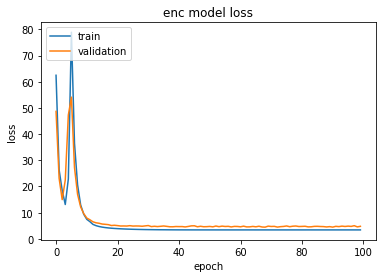

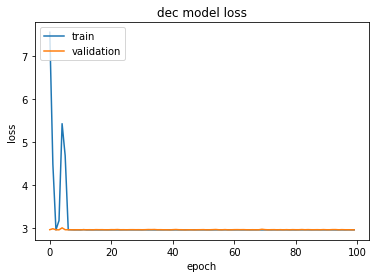

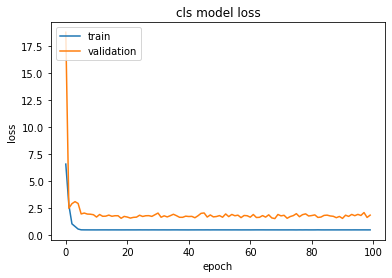

In [103]:
print(H.history.keys())

# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('enc model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#  "model_loss"
plt.plot(H.history[dec_name+'_loss'])
plt.plot(H.history['val_'+dec_name+'_loss'])
plt.title('dec model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#  "model_loss"
plt.plot(H.history[cls_name+'_loss'])
plt.plot(H.history['val_'+cls_name+'_loss'])
plt.title('cls model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'model_25_loss', 'sequential_8_loss', 'val_loss', 'val_model_25_loss', 'val_sequential_8_loss'])


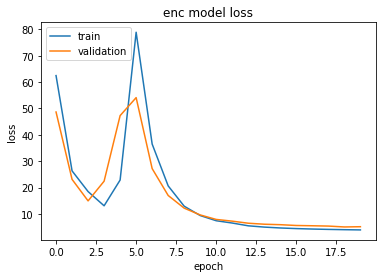

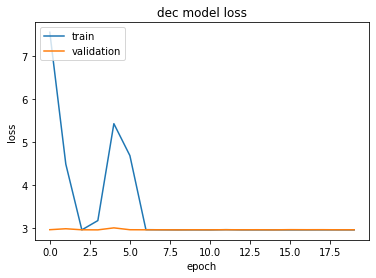

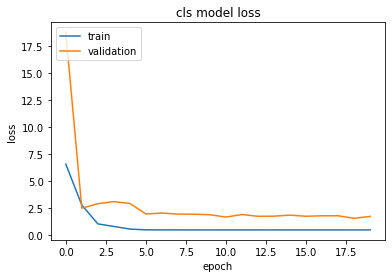

In [104]:
print(H.history.keys())

zoom_start, zoom_end = 0, 20

# "Loss"
plt.plot(H.history['loss'][zoom_start:zoom_end])
plt.plot(H.history['val_loss'][zoom_start:zoom_end])
plt.title('enc model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#  "model_loss"
plt.plot(H.history[dec_name+'_loss'][zoom_start:zoom_end])
plt.plot(H.history['val_'+dec_name+'_loss'][zoom_start:zoom_end])
plt.title('dec model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#  "model_loss"
plt.plot(H.history[cls_name+'_loss'][zoom_start:zoom_end])
plt.plot(H.history['val_'+cls_name+'_loss'][zoom_start:zoom_end])
plt.title('cls model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [101]:
H.history['loss'][0:10]

[62.457908630371094,
 26.353506088256836,
 18.513540267944336,
 13.119171142578125,
 22.885663986206055,
 78.8897476196289,
 36.51493835449219,
 20.661020278930664,
 12.965540885925293,
 9.421745300292969]

In [102]:
len(H.history['loss'])

100

# Encoded features using DANN

In [33]:
train_enc_features = enc.predict(train_features)
indpe_enc_features = enc.predict(indpe_features)

# Build folds using encoded training features

In [34]:
folds = build_kfold(train_enc_features, train_labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

# Training Evaluation

In [35]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}
        
##################################################################################
##### extract data from the current fasta file
##################################################################################

print("\n======================================================================")
print("Training Positive:", np.sum(train_labels))
print("Training Negative:", train_labels.shape[0] - np.sum(train_labels))
print("Independent Positive:", np.sum(indpe_labels))
print("Independent Negative:", indpe_labels.shape[0] - np.sum(indpe_labels))

##################################################################################
##### TRAIN and PREDICT for every Fold, using models
##################################################################################

# fold counter
i = 0

for fold in folds:

    # adding random shuffling of the dataset for training purpose
    randomized_index_arr = np.arange(fold["X_train"].shape[0])
    randomized_index_arr = np.random.permutation(randomized_index_arr)

    print("\nTrain/Test model on Fold #"+str(i)+".")

    model_file_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))

    model = get_model()
    
#     ## Define the model callbacks for early stopping and saving the model. Then train model.
#     modelCallbacks = [
#         tf.keras.callbacks.ModelCheckpoint(model_file_path,
#                                            monitor = 'val_loss', verbose = 1, save_best_only = True, 
#                                            save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
#     ]
#     model.fit(x = fold["X_train"][randomized_index_arr], y = fold["y_train"][randomized_index_arr], 
#               batch_size = batch_size, epochs = epochs, verbose = 1, 
#               callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))
    
#     model = tf.keras.models.load_model(current_model_path)

    model.fit(X = fold["X_train"][randomized_index_arr], y = fold["y_train"][randomized_index_arr])

    model_file_obj = open(model_file_path, 'wb')
    pickle.dump(model, model_file_obj)
    model_file_obj.close()

    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

    i = i+1

##################################################################################
##### Independent Data performance
##################################################################################

print("\nIndependent evaluation for model.")

# adding random shuffling of the dataset for training purpose
randomized_index_arr = np.arange(train_enc_features.shape[0])
randomized_index_arr = np.random.permutation(randomized_index_arr)

model_file_path = os.path.join(modelPath, "bestModel-full.hdf5")

# ## Define the model callbacks for early stopping and saving the model. Then train model.
# modelCallbacks = [
#     tf.keras.callbacks.ModelCheckpoint(model_file_path,
#                                        monitor = 'val_loss', verbose = 1, save_best_only = True, 
#                                        save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
# ]
# model.fit(x = train_enc_features[randomized_index_arr], y = train_labels[randomized_index_arr], 
#           batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_data = (indpe_enc_features, indpe_labels))

# model = tf.keras.models.load_model(current_model_path)

model = get_model()

model.fit(X = train_enc_features[randomized_index_arr], y = train_labels[randomized_index_arr])

model_file_obj = open(model_file_path, 'wb')
pickle.dump(model, model_file_obj)
model_file_obj.close()

##################################################################################
##### Prediction and metrics for TEST dataset
##################################################################################

y_pred = model.predict(indpe_enc_features)
label_pred = pred2label(y_pred)
# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Fold"].append(i)
evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "wb"))


Training Positive: 1191
Training Negative: 1191
Independent Positive: 203
Independent Negative: 1022

Train/Test model on Fold #0.

Train/Test model on Fold #1.

Train/Test model on Fold #2.

Train/Test model on Fold #3.

Train/Test model on Fold #4.

Independent evaluation for model.


In [36]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.745306,0.231527,0.539443,0.231527,0.847358,0.078885
Test,0.540714,0.605532,0.540765,0.247751,0.833779,0.102813
Train,0.650923,0.860001,0.650917,0.362496,0.939338,0.370477


In [37]:
# latent_dim_size 100

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.573878	0.182903	0.525525	0.453202	0.597847	0.038584
# Test	0.591107	0.595660	0.591136	0.575142	0.607131	0.182756
# Train	0.996642	0.997688	0.996641	0.995592	0.997691	0.993287

In [38]:
# def get_model():
    
# #     model = RandomForestClassifier(n_estimators=10, 
# #                                    criterion='gini', 
# #                                    bootstrap=True,
# #                                    oob_score=True)

# #     model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False,
# #                               learn_rate=0.001, eta=0.1, eval_metric='auc'
# #                              )

#     model = xgb.XGBClassifier(objective="binary:logistic", 
#                               eval_metric='logloss',
#                               use_label_encoder=False, 
#                               max_depth=10,
#                               reg_lambda=0.001,
#                               learning_rate=0.001
#                              )
    
# #     model = SVC(kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False,
# #                 tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=100, decision_function_shape='ovr', 
# #                 break_ties=False, random_state=None)

# #     model = tf.keras.models.Sequential()
# #     model.add(tf.keras.layers.Input(shape=(latent_dim_size,)))
# #     model.add(tf.keras.layers.Dense(32,
# #                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# #     model.add(tf.keras.layers.Activation('relu'))
# #     model.add(tf.keras.layers.Dropout(0.5))
# #     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# #     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), 
# #                   loss='binary_crossentropy', 
# #                   metrics=None)
    
#     return model

In [39]:
from sklearn.decomposition import PCA, KernelPCA

In [40]:
pca = PCA(n_components=3)
pca.fit(np.concatenate((train_enc_features, indpe_enc_features)))
# pca.fit(indpe_enc_features)
print(sum(pca.explained_variance_ratio_), ' : ', pca.explained_variance_ratio_)

0.9999447080190293  :  [9.9959552e-01 2.7701995e-04 7.2165189e-05]


In [41]:
pca.components_.shape

(3, 100)

In [42]:
pca.components_[0]

array([-0.06780291,  0.04190223,  0.14710325, -0.06525796,  0.13202979,
        0.09910974,  0.09882925,  0.00897758, -0.01456789,  0.0716381 ,
       -0.19385365, -0.02724968, -0.16268648, -0.09122453, -0.22109866,
       -0.03706009, -0.15897079, -0.05577906,  0.03439904,  0.09335504,
        0.21725601, -0.0036644 ,  0.13687287,  0.05528205,  0.01015192,
        0.07488634, -0.03201872,  0.07204974, -0.10876941, -0.03998029,
        0.10478482,  0.10484733,  0.07342096, -0.11476815, -0.04223066,
       -0.04036947, -0.03217112, -0.02778234,  0.0275334 ,  0.11952853,
       -0.00986587, -0.07570324, -0.05720895, -0.01738827, -0.01994591,
        0.05577999,  0.08074152, -0.20221224,  0.11122423, -0.01324127,
       -0.16660996,  0.03038757, -0.03789619, -0.00273802,  0.1938962 ,
       -0.29993817, -0.05455019, -0.04197693, -0.17623678, -0.10703215,
        0.02571701,  0.03195028, -0.0392996 , -0.09351904, -0.06842286,
       -0.01185048, -0.1128097 , -0.1207267 ,  0.22417216, -0.02

In [43]:
# transformer = KernelPCA(n_components=7, kernel='rbf')
# transformer.fit(np.concatenate((train_enc_features, indpe_enc_features)))
# print(sum(transformer.explained_variance_ratio_), ' : ', transformer.explained_variance_ratio_)

In [44]:
import matplotlib.pyplot as plt